In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

model = XGBClassifier(eval_metric='logloss')
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
df = pd.read_excel('/content/wipro.csv.xlsx')
df

,Company Name,Company Location,Year,Annual Revenue (Million USD),Market Share (%),Number of Employees Before Layoff,Number of Employees After Layoff,Layoff Impact (Yes/No),Total Assets (Million USD),Number of Laid Off,Date of Layoff,Revenue per Employee (Million USD),Customer Satisfaction (%),Innovation Index (1-10),Digital Transformation Spend (%),R&D Investment (Million USD)
0,Wipro,"Bengaluru, India",2000,350,5.0,7500,7500,No,1200,0,2000-02-10,0.047,75,6,3.5,25
1,Wipro,"Bengaluru, India",2001,420,5.5,8000,7800,Yes,1400,200,2001-07-15,0.053,72,5,4.0,28
2,Wipro,"Bengaluru, India",2002,510,6.2,8500,8400,Yes,1600,100,2002-03-20,0.060,74,6,4.5,30
3,Wipro,"New York, USA",2003,600,7.0,9000,9000,No,1800,0,2003-06-10,0.067,77,7,5.0,35
4,Wipro,"Bengaluru, India",2004,700,7.5,9500,9500,No,2000,0,2004-09-15,0.074,80,8,5.5,38
5,Wipro,"London, UK",2005,800,8.0,10000,10000,No,2300,0,2005-04-05,0.080,79,7,6.0,40
6,Wipro,"Toronto, Canada",2006,1000,8.5,11000,10850,Yes,2500,150,2006-06-25,0.091,81,8,6.5,45
7,Wipro,Singapore,2007,1100,9.0,12000,11750,Yes,2700,250,2007-08-19,0.092,85,9,7.0,48
8,Wipro,"Sydney, Australia",2008,1300,9.5,12500,12500,No,3000,0,2008-03-17,0.104,83,8,8.0,50
9,Wipro,"Dubai, UAE",2009,1400,10.0,13000,12900,Yes,3200,100,2009-02-10,0.108,86,8,8.5,52


In [ ]:
# Step 1: Add binary target - Layoff_Event
df['Layoff_Event'] = (df['Number of Laid Off'] > 0).astype(int)

In [ ]:
# Step 2: Simulate a few 'no-layoff' records
no_layoff_data = {
    'Company Name': ['Wipro', 'Wipro', 'Wipro'],
    'Company Location': ['Berlin, Germany', 'Tokyo, Japan', 'Cape Town, South Africa'],
    'Year': [2025, 2025, 2025],
    'Annual Revenue (Million USD)': [7000, 7200, 7100],
    'Market Share (%)': [18.0, 18.5, 18.2],
    'Number of Employees Before Layoff': [29000, 29500, 29200],
    'Number of Employees After Layoff': [29000, 29500, 29200],
    'Layoff Impact (Yes/No)': ['No', 'No', 'No'],
    'Total Assets (Million USD)': [8600, 8700, 8650],
    'Number of Laid Off': [0, 0, 0],
    'Date of Layoff': ['2025-06-15', '2025-07-01', '2025-07-20'],
    'Revenue per Employee (Million USD)': [0.241, 0.244, 0.243],
    'Customer Satisfaction (%)': [99, 98, 97],
    'Innovation Index (1-10)': [10, 10, 9],
    'Digital Transformation Spend (%)': [21.0, 21.5, 21.2],
    'R&D Investment (Million USD)': [125, 130, 127]
}

no_layoff_df = pd.DataFrame(no_layoff_data)

# Append to the original dataframe
df = pd.concat([df, no_layoff_df], ignore_index=True)


In [ ]:
# Step 3: Feature selection
features = [
    'Year', 'Company Location', 'Annual Revenue (Million USD)',
    'Market Share (%)', 'Number of Employees Before Layoff',
    'Total Assets (Million USD)', 'Revenue per Employee (Million USD)',
    'Customer Satisfaction (%)', 'Innovation Index (1-10)',
    'Digital Transformation Spend (%)', 'R&D Investment (Million USD)',
    'Date of Layoff'  # Include 'Date of Layoff' in the features list
]

X = df[features]
y = df['Layoff Impact (Yes/No)']


In [ ]:
# Step 4: Encode categorical features
label_encoders = {}

# Store original X for use after future_data is created
X_original = X.copy()

# Encode 'Company Location' using LabelEncoder
categorical_columns = ['Company Location']

for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

<ipython-input-61-482ccbdbed00>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])


In [ ]:
# Step 5: Handle datetime
X_original['Date of Layoff'] = pd.to_datetime(X_original['Date of Layoff'], format='%Y-%m-%d', errors='coerce')
X_original['Layoff Year'] = X_original['Date of Layoff'].dt.year
X_original['Layoff Month'] = X_original['Date of Layoff'].dt.month
X_original['Layoff Day'] = X_original['Date of Layoff'].dt.day
X_original = X_original.drop('Date of Layoff', axis=1)

In [ ]:
# Step 6: Feature scaling
numerical_features = [
    'Layoff Year', 'Layoff Month', 'Layoff Day',
    'Number of Employees Before Layoff', 'Annual Revenue (Million USD)',
    'Total Assets (Million USD)', 'Revenue per Employee (Million USD)',
    'Customer Satisfaction (%)', 'Innovation Index (1-10)',
    'Digital Transformation Spend (%)', 'R&D Investment (Million USD)'
]

scaler = StandardScaler()
X_scaled = X_original.copy()
X_scaled[numerical_features] = scaler.fit_transform(X_scaled[numerical_features])


In [ ]:
future_data = pd.DataFrame([{
    'Company Location': 'India',
    'Annual Revenue (Million USD)': 12000,   # Example value
    'Market Share (%)': 5.0,                 # Example value
    'Number of Employees Before Layoff': 240000,
    'Total Assets (Million USD)': 16000,     # Example value
    'Revenue per Employee (Million USD)': 0.05,  # Example value
    'Customer Satisfaction (%)': 85.0,       # Example value
    'Innovation Index (1-10)': 6.5,          # Example value
    'Digital Transformation Spend (%)': 8.0, # Example value
    'R&D Investment (Million USD)': 500,     # Example value
    'Layoff Year': 2025,
    'Layoff Month': 4,
    'Layoff Day': 6,
    'Year': 2025
}])


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Fit LabelEncoders on combined unique values for 'Company Location'
for col in ['Company Location']:
    le = LabelEncoder()
    # Get unique values from X_original['Company Location'] as strings
    all_values = X_original[col].astype(str).unique().tolist()
    # Extend with unique values from future_data['Company Location']
    all_values.extend(future_data[col].astype(str).unique().tolist())

    le.fit(all_values)  # Now fitting on all strings

    X_scaled[col] = le.transform(X_original[col].astype(str))  # Applying to the original data
    future_data[col] = le.transform(future_data[col].astype(str))  # Applying to the future data

    label_encoders[col] = le

# No need to convert 'Date of Layoff' as it's already split into year, month, day
# Instead, select the same features as in X_train to ensure consistency
future_data = future_data[X_train.columns]  # Use this line to select the relevant columns

# Scale numeric features
future_data[numerical_features] = scaler.transform(future_data[numerical_features])

In [ ]:
from sklearn.model_selection import train_test_split

# Step 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# — Ensure your target is numeric —
y_numeric = y.map({'No': 0, 'Yes': 1})

# — Re-do the train-test split on the numeric target —
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

# — Step 8: Train classifier —
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_auc_score
)

# Step 9: Evaluate

# Test predictions & probabilities
y_pred_test = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)[:, 1]

# Train predictions
y_pred_train = model.predict(X_train)

# — Confusion Matrices —
print("Confusion Matrix (WIPRO):")
print(confusion_matrix(y_train, y_pred_train))

# — Accuracy Scores —
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"\nTraining Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy:     {test_acc * 100:.2f}%")

# — Classification Reports —
print("\nTraining Classification Report(WIPRO):")
print(classification_report(y_train, y_pred_train))


# — ROC AUC on Test Set —
roc_auc = roc_auc_score(y_test, y_proba_test)


Confusion Matrix (WIPRO):
[[16  0]
 [ 1  5]]

Training Accuracy: 95.45%
Test Accuracy:     33.33%

Training Classification Report(WIPRO):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.83      0.91         6

    accuracy                           0.95        22
   macro avg       0.97      0.92      0.94        22
weighted avg       0.96      0.95      0.95        22



In [ ]:
print(X_train.columns.tolist())

['Year', 'Company Location', 'Annual Revenue (Million USD)', 'Market Share (%)', 'Number of Employees Before Layoff', 'Total Assets (Million USD)', 'Revenue per Employee (Million USD)', 'Customer Satisfaction (%)', 'Innovation Index (1-10)', 'Digital Transformation Spend (%)', 'R&D Investment (Million USD)', 'Layoff Year', 'Layoff Month', 'Layoff Day']


In [ ]:
# Reorder columns to match training data
future_data = future_data[X_train.columns]

# Predict
future_pred = model.predict(future_data)
future_proba = model.predict_proba(future_data)

print("Layoff Prediction (WIPRO)")
print("Layoff Prediction for 2025:", "YES" if future_pred[0] == 1 else "NO")
print("Layoff Probability: {:.2f}%".format(future_proba[0][1] * 100))


Layoff Prediction (WIPRO)
Layoff Prediction for 2025: NO
Layoff Probability: 31.25%


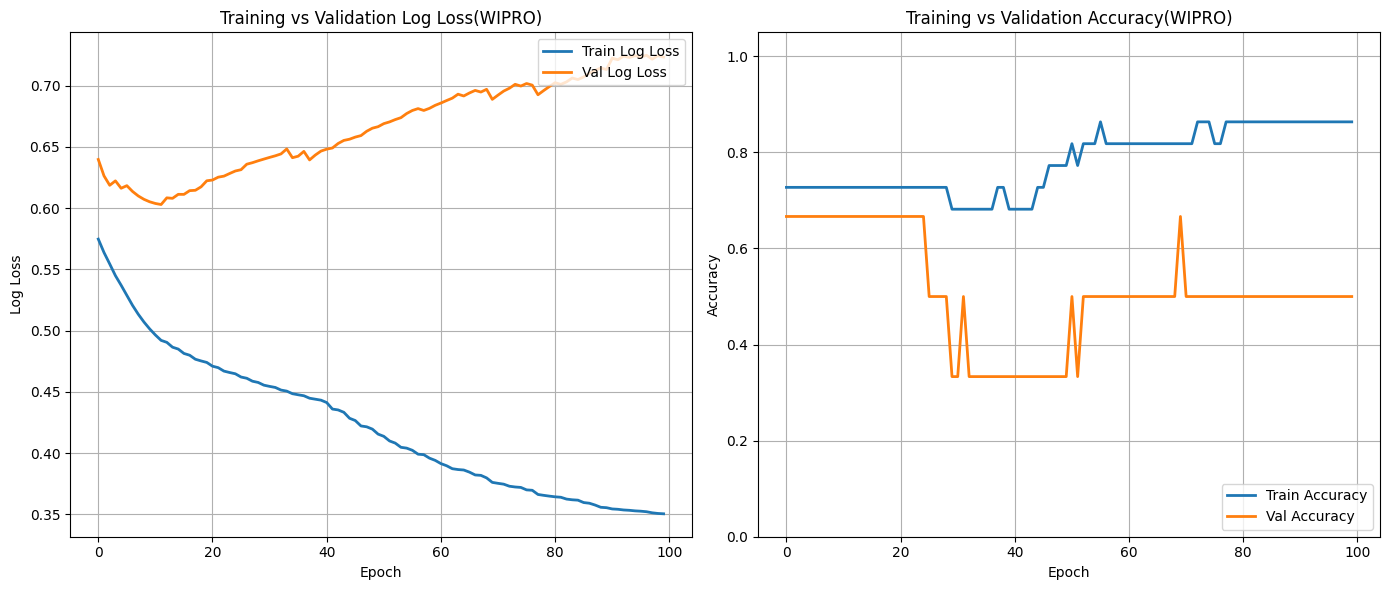

In [ ]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# 1. Prepare the eval set
eval_set = [(X_train, y_train), (X_test, y_test)]

# 2. Instantiate with metrics to track
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric=['logloss', 'error'],  # specify here
    n_estimators=100,
    learning_rate=0.1
)

# 3. Fit without passing eval_metric again
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

# 4. Extract evaluation history
results = model.evals_result()

# 5. Number of boosting rounds (epochs)
epochs = len(results['validation_0']['logloss'])
x_axis = range(epochs)

# 6. Plot Log Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(x_axis, results['validation_0']['logloss'], label='Train Log Loss', lw=2)
plt.plot(x_axis, results['validation_1']['logloss'], label='Val Log Loss',   lw=2)
plt.title('Training vs Validation Log Loss(WIPRO)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend(loc='upper right')
plt.grid(True)

# 7. Plot Accuracy = 1 − error
train_acc = [1 - err for err in results['validation_0']['error']]
val_acc   = [1 - err for err in results['validation_1']['error']]

plt.subplot(1, 2, 2)
plt.plot(x_axis, train_acc, label='Train Accuracy', lw=2)
plt.plot(x_axis, val_acc,   label='Val Accuracy',   lw=2)
plt.title('Training vs Validation Accuracy(WIPRO)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

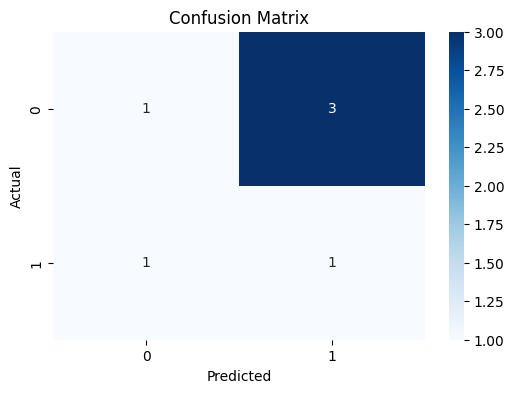

In [ ]:
# VALIDATION PLOTS
# Confusion Matrix Plot
plt.figure(figsize=(6,4))
# Replace y_pred with y_pred_test
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

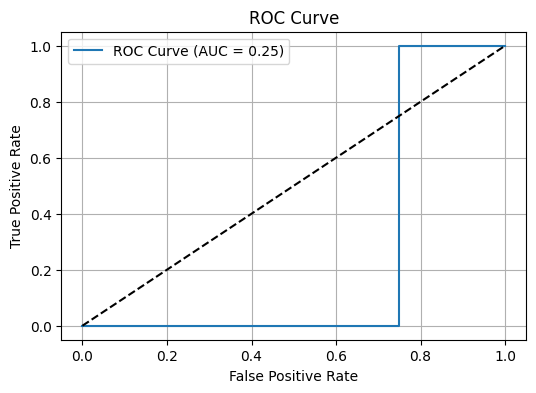

In [ ]:
# ROC Curve
# — Assign y_proba_test to y_proba to use in the ROC Curve —
y_proba = y_proba_test
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

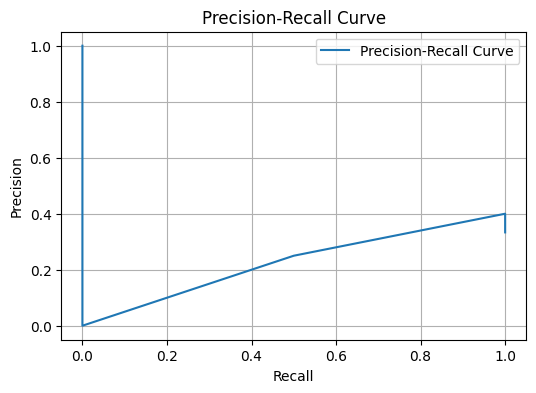

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

<Figure size 800x600 with 0 Axes>

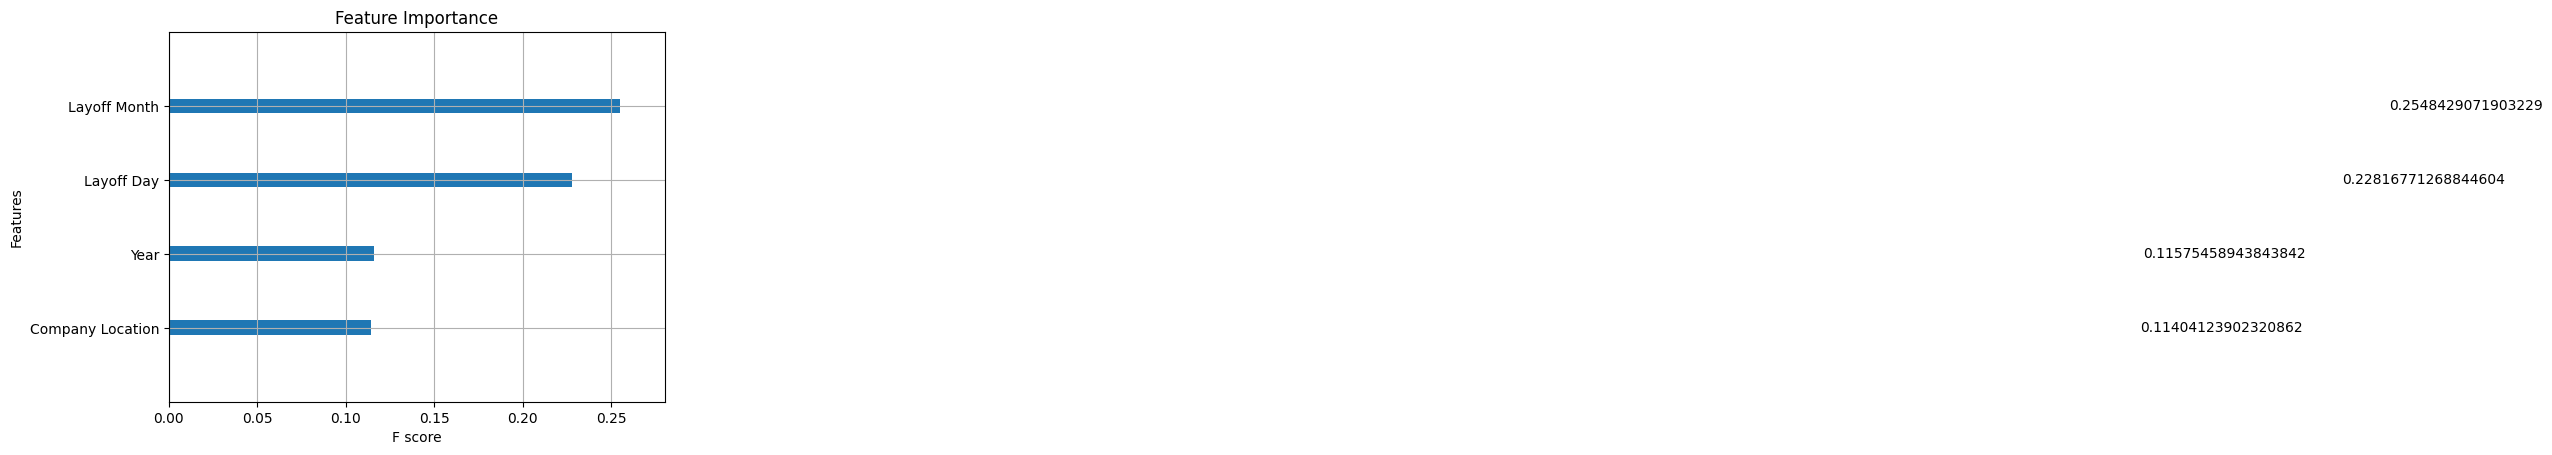

In [ ]:
# Feature Importance
plt.figure(figsize=(8,6))
plot_importance(model, importance_type='gain', title='Feature Importance', max_num_features=10)
plt.show()